In [2]:
from gensim.models import KeyedVectors

file = '../CH7 Word-embedding/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(file, binary=True)

# データのロード
import pandas as pd
import re
import numpy as np

# ファイル読み込み
file = '../CH6 Machine-learning/newsCorpora.csv'
data = pd.read_csv(file, encoding='utf-8', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
data = data.replace('"', "'")
# 特定のpublisherのみ抽出
publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
data = data.loc[data['PUBLISHER'].isin(publishers), ['TITLE', 'CATEGORY']].reset_index(drop=True)

# 学習用、検証用、評価用に分割する
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=64, stratify=data['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=64, stratify=valid_test['CATEGORY'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

# データ数の確認
print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

import re
from nltk import stem

# データの結合
df = pd.concat([train, valid, test], axis=0).reset_index(drop=True)

# 前処理
def preprocessing(text):
    text_clean = re.sub(r'[\"\'.,:;\(\)#\|\*\+\!\?#$%&/\]\[\{\}]', '', text)
    text_clean = re.sub('[0-9]+', '0', text_clean)
    text_clean = re.sub('\s-\s', ' ', text_clean)
    return text_clean

df['TITLE'] = df['TITLE'].apply(preprocessing)

学習データ
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
検証データ
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
評価データ
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


In [5]:
import numpy as np
# 平均単語ベクトルの取得
def w2v(text):
    words = text.rstrip().split()
    vec = [model[word] for word in words if word in model]
    return np.array(sum(vec) / len(vec))

vecs = np.array([])
for text in df['TITLE']:
    if len(vecs) == 0:
        vecs = w2v(text)
    else:
        vecs = np.vstack([vecs, w2v(text)])

# 特徴ベクトルのテンソル化
import torch

# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)

X_train = torch.from_numpy(vecs[:len(train), :])
X_valid = torch.from_numpy(vecs[len(train):len(train)+ len(valid), :])
X_test = torch.from_numpy(vecs[len(train)+ len(valid):, :])
print(X_train.size())
print(X_train)


torch.Size([10672, 300])
tensor([[ 0.0368,  0.0300, -0.0738,  ..., -0.1523,  0.0419, -0.0774],
        [ 0.0002, -0.0056, -0.0824,  ..., -0.0544,  0.0776, -0.0214],
        [ 0.0266, -0.0166, -0.0877,  ..., -0.0522,  0.0517,  0.0093],
        ...,
        [-0.0291,  0.0529, -0.1453,  ...,  0.0494,  0.1548, -0.0910],
        [-0.0269,  0.1204, -0.0289,  ..., -0.0062,  0.0739, -0.0327],
        [ 0.0361,  0.1236,  0.0260,  ..., -0.0099, -0.0193,  0.0262]])


In [4]:
# ターゲットのテンソル化
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
Y_train = torch.from_numpy(train['CATEGORY'].map(category_dict).values)
Y_valid = torch.from_numpy(valid['CATEGORY'].map(category_dict).values)
Y_test = torch.from_numpy(test['CATEGORY'].map(category_dict).values)
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(Y_train, 'y_train.pt')
torch.save(Y_valid, 'y_valid.pt')
torch.save(Y_test, 'y_test.pt')

In [6]:
# モデルの構築
from torch import nn

class SLNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        logits = self.fc(x)
        return logits

model = SLNet(300, 4)
print(model)

SLNet(
  (fc): Linear(in_features=300, out_features=4, bias=True)
)


In [7]:
logits = model(X_train[0])
y_hat_1 = nn.Softmax(dim=-1)(logits)
print(logits)
print(y_hat_1)

tensor([-0.0176,  0.0697,  0.0920,  0.0596], grad_fn=<AddBackward0>)
tensor([0.2332, 0.2545, 0.2603, 0.2520], grad_fn=<SoftmaxBackward>)


In [8]:
logits = model(X_train[:4])
Y_hat = nn.Softmax(dim=1)(logits)
print(logits)
print(Y_hat)

tensor([[-0.0176,  0.0697,  0.0920,  0.0596],
        [-0.0210,  0.0704,  0.0814,  0.0636],
        [ 0.0360,  0.1010,  0.0704,  0.0456],
        [ 0.0362,  0.1266,  0.0222,  0.1343]], grad_fn=<AddmmBackward>)
tensor([[0.2332, 0.2545, 0.2603, 0.2520],
        [0.2330, 0.2553, 0.2581, 0.2536],
        [0.2432, 0.2595, 0.2517, 0.2455],
        [0.2390, 0.2616, 0.2357, 0.2637]], grad_fn=<SoftmaxBackward>)


In [12]:
# x_1のロスを求める
criterion = nn.CrossEntropyLoss()
logits = model(X_train[:4])
loss = criterion(logits, Y_train[:4])
print("損失: ", loss.item())
model.zero_grad()
loss.backward()
print("勾配: ")
print(model.fc.weight.grad)

損失:  1.3807432651519775
勾配: 
tensor([[ 5.0444e-03,  3.9170e-03,  7.1611e-03,  ..., -2.0513e-03,
         -4.2177e-03,  5.3509e-04],
        [ 3.9538e-05, -6.0439e-03, -1.8717e-02,  ..., -1.5257e-02,
         -4.6948e-03, -6.8699e-03],
        [-1.0491e-02, -7.2170e-04,  2.5712e-02,  ...,  3.4016e-02,
         -7.4130e-03,  1.1578e-02],
        [ 5.4069e-03,  2.8486e-03, -1.4156e-02,  ..., -1.6707e-02,
          1.6325e-02, -5.2435e-03]])


In [13]:
# データセットを作成する
import torch.utils.data as data

class NewsDataset(data.Dataset):
    """
    newsのDatasetクラス
    
    Attributes
    ----------------------------
    X : テンソル
        単語ベクトルの平均をまとめたテンソル
    y : テンソル
        カテゴリをラベル化したテンソル
    phase : 'train' or 'val'
        学習か訓練かを設定する
    """
    def __init__(self, X, y, phase='train'):
        self.X = X
        self.y = y
        self.phase = phase
    
    def __len__(self):
        """全データサイズを返す"""
        return len(self.y)
    
    def __getitem__(self, idx):
        """idxに対応するテンソル形式のデータとラベルを取得"""
        return self.X[idx], self.y[idx]

train_dataset = NewsDataset(X_train, Y_train, phase='train')
valid_dataset = NewsDataset(X_valid, Y_valid, phase='val')
test_dataset = NewsDataset(X_test, Y_test, phase='val')

# 動作確認
idx = 0
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])
print(valid_dataset.__getitem__(idx)[0].size())
print(valid_dataset.__getitem__(idx)[1])
print(test_dataset.__getitem__(idx)[0].size())
print(test_dataset.__getitem__(idx)[1])


torch.Size([300])
tensor(2)
torch.Size([300])
tensor(3)
torch.Size([300])
tensor(2)


In [14]:
# DataLoaderを作成
batch_size = 1

train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = data.DataLoader(
            test_dataset, batch_size=len(test_dataset), shuffle=False)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }

# 動作確認
batch_iter = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iter)
print(inputs.size())
print(labels)

torch.Size([1, 300])
tensor([2])


In [15]:
from tqdm import tqdm
# 学習

# モデルの定義
net = SLNet(300, 4)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('--------------------------------------------')
        
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード
            
            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数
            
            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad() # optimizerを初期化
                
                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想
                    
                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)
            
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            
# 学習を実行する
num_epochs = 100
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2055.45it/s]


train Loss: 0.4169, Acc: 0.8569


100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


val Loss: 0.3204, Acc: 0.8936
Epoch 2 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2093.67it/s]


train Loss: 0.3108, Acc: 0.8925


100%|██████████| 1/1 [00:00<00:00, 33.14it/s]


val Loss: 0.2800, Acc: 0.9055
Epoch 3 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3240.76it/s]


train Loss: 0.2897, Acc: 0.8996


100%|██████████| 1/1 [00:00<00:00, 75.47it/s]


val Loss: 0.2809, Acc: 0.9063
Epoch 4 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3406.80it/s]


train Loss: 0.2794, Acc: 0.9027


100%|██████████| 1/1 [00:00<00:00, 152.11it/s]


val Loss: 0.2728, Acc: 0.9123
Epoch 5 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3470.09it/s]


train Loss: 0.2718, Acc: 0.9055


100%|██████████| 1/1 [00:00<00:00, 137.60it/s]


val Loss: 0.2681, Acc: 0.9100
Epoch 6 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3138.35it/s]


train Loss: 0.2642, Acc: 0.9096


100%|██████████| 1/1 [00:00<00:00, 124.97it/s]


val Loss: 0.2768, Acc: 0.9078
Epoch 7 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3252.16it/s]


train Loss: 0.2600, Acc: 0.9117


100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


val Loss: 0.2788, Acc: 0.9055
Epoch 8 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 2945.13it/s]


train Loss: 0.2576, Acc: 0.9116


100%|██████████| 1/1 [00:00<00:00, 89.34it/s]


val Loss: 0.2700, Acc: 0.9085
Epoch 9 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2100.08it/s]


train Loss: 0.2551, Acc: 0.9125


100%|██████████| 1/1 [00:00<00:00, 14.64it/s]


val Loss: 0.2748, Acc: 0.9160
Epoch 10 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2090.87it/s]


train Loss: 0.2530, Acc: 0.9136


100%|██████████| 1/1 [00:00<00:00, 29.92it/s]


val Loss: 0.2691, Acc: 0.9115
Epoch 11 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2093.64it/s]


train Loss: 0.2503, Acc: 0.9145


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


val Loss: 0.2736, Acc: 0.9138
Epoch 12 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3418.13it/s]


train Loss: 0.2483, Acc: 0.9141


100%|██████████| 1/1 [00:00<00:00, 118.61it/s]


val Loss: 0.2729, Acc: 0.9130
Epoch 13 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3335.06it/s]


train Loss: 0.2479, Acc: 0.9148


100%|██████████| 1/1 [00:00<00:00, 119.85it/s]


val Loss: 0.2770, Acc: 0.9040
Epoch 14 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3334.97it/s]


train Loss: 0.2467, Acc: 0.9149


100%|██████████| 1/1 [00:00<00:00, 36.81it/s]


val Loss: 0.2750, Acc: 0.9145
Epoch 15 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3303.84it/s]


train Loss: 0.2462, Acc: 0.9139


100%|██████████| 1/1 [00:00<00:00, 16.86it/s]


val Loss: 0.2784, Acc: 0.9085
Epoch 16 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3392.24it/s]


train Loss: 0.2438, Acc: 0.9179


100%|██████████| 1/1 [00:00<00:00, 32.77it/s]


val Loss: 0.2752, Acc: 0.9100
Epoch 17 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3272.89it/s]


train Loss: 0.2443, Acc: 0.9147


100%|██████████| 1/1 [00:00<00:00, 46.93it/s]


val Loss: 0.2741, Acc: 0.9055
Epoch 18 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 2743.62it/s]


train Loss: 0.2425, Acc: 0.9145


100%|██████████| 1/1 [00:00<00:00, 16.75it/s]


val Loss: 0.2972, Acc: 0.8928
Epoch 19 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3257.68it/s]


train Loss: 0.2420, Acc: 0.9174


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


val Loss: 0.2801, Acc: 0.9078
Epoch 20 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3181.37it/s]


train Loss: 0.2411, Acc: 0.9158


100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


val Loss: 0.2825, Acc: 0.9100
Epoch 21 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3184.52it/s]


train Loss: 0.2410, Acc: 0.9162


100%|██████████| 1/1 [00:00<00:00, 71.67it/s]


val Loss: 0.2833, Acc: 0.9055
Epoch 22 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2130.51it/s]


train Loss: 0.2395, Acc: 0.9165


100%|██████████| 1/1 [00:00<00:00, 16.48it/s]


val Loss: 0.2776, Acc: 0.9055
Epoch 23 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 2931.77it/s]


train Loss: 0.2396, Acc: 0.9170


100%|██████████| 1/1 [00:00<00:00, 113.99it/s]


val Loss: 0.2807, Acc: 0.9063
Epoch 24 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3386.28it/s]


train Loss: 0.2385, Acc: 0.9170


100%|██████████| 1/1 [00:00<00:00, 21.90it/s]


val Loss: 0.2869, Acc: 0.9100
Epoch 25 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2129.36it/s]


train Loss: 0.2392, Acc: 0.9169


100%|██████████| 1/1 [00:00<00:00, 14.02it/s]


val Loss: 0.2828, Acc: 0.9093
Epoch 26 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2099.77it/s]


train Loss: 0.2387, Acc: 0.9177


100%|██████████| 1/1 [00:00<00:00, 38.07it/s]


val Loss: 0.2836, Acc: 0.9070
Epoch 27 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2209.13it/s]


train Loss: 0.2377, Acc: 0.9173


100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


val Loss: 0.2846, Acc: 0.9078
Epoch 28 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2099.50it/s]


train Loss: 0.2375, Acc: 0.9173


100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


val Loss: 0.2900, Acc: 0.9010
Epoch 29 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2083.08it/s]


train Loss: 0.2366, Acc: 0.9177


100%|██████████| 1/1 [00:00<00:00, 40.52it/s]


val Loss: 0.2930, Acc: 0.9003
Epoch 30 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2100.57it/s]


train Loss: 0.2380, Acc: 0.9146


100%|██████████| 1/1 [00:00<00:00, 15.92it/s]


val Loss: 0.2816, Acc: 0.9078
Epoch 31 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3352.06it/s]


train Loss: 0.2374, Acc: 0.9171


100%|██████████| 1/1 [00:00<00:00, 131.02it/s]


val Loss: 0.2860, Acc: 0.9063
Epoch 32 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3340.16it/s]


train Loss: 0.2364, Acc: 0.9172


100%|██████████| 1/1 [00:00<00:00, 13.59it/s]


val Loss: 0.2843, Acc: 0.9085
Epoch 33 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3174.45it/s]


train Loss: 0.2367, Acc: 0.9174


100%|██████████| 1/1 [00:00<00:00, 32.82it/s]


val Loss: 0.2877, Acc: 0.9078
Epoch 34 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3262.31it/s]


train Loss: 0.2377, Acc: 0.9157


100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


val Loss: 0.2872, Acc: 0.9093
Epoch 35 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3439.90it/s]


train Loss: 0.2351, Acc: 0.9186


100%|██████████| 1/1 [00:00<00:00, 97.84it/s]


val Loss: 0.2888, Acc: 0.9055
Epoch 36 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3393.11it/s]


train Loss: 0.2368, Acc: 0.9178


100%|██████████| 1/1 [00:00<00:00, 91.57it/s]


val Loss: 0.2839, Acc: 0.9063
Epoch 37 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3451.14it/s]


train Loss: 0.2359, Acc: 0.9179


100%|██████████| 1/1 [00:00<00:00, 126.22it/s]


val Loss: 0.2920, Acc: 0.9070
Epoch 38 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3444.90it/s]


train Loss: 0.2362, Acc: 0.9147


100%|██████████| 1/1 [00:00<00:00, 144.29it/s]


val Loss: 0.2920, Acc: 0.9048
Epoch 39 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3352.73it/s]


train Loss: 0.2351, Acc: 0.9180


100%|██████████| 1/1 [00:00<00:00, 29.75it/s]


val Loss: 0.2942, Acc: 0.9048
Epoch 40 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3306.11it/s]


train Loss: 0.2359, Acc: 0.9170


100%|██████████| 1/1 [00:00<00:00, 127.44it/s]


val Loss: 0.2872, Acc: 0.9033
Epoch 41 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3371.15it/s]


train Loss: 0.2348, Acc: 0.9190


100%|██████████| 1/1 [00:00<00:00, 112.64it/s]


val Loss: 0.2871, Acc: 0.8996
Epoch 42 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3368.72it/s]


train Loss: 0.2351, Acc: 0.9175


100%|██████████| 1/1 [00:00<00:00, 137.51it/s]


val Loss: 0.2907, Acc: 0.9048
Epoch 43 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3416.13it/s]


train Loss: 0.2337, Acc: 0.9186


100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


val Loss: 0.2911, Acc: 0.9033
Epoch 44 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3348.73it/s]


train Loss: 0.2352, Acc: 0.9175


100%|██████████| 1/1 [00:00<00:00, 56.34it/s]


val Loss: 0.2904, Acc: 0.9055
Epoch 45 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3389.94it/s]


train Loss: 0.2337, Acc: 0.9179


100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


val Loss: 0.2913, Acc: 0.9055
Epoch 46 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 2986.36it/s]


train Loss: 0.2345, Acc: 0.9193


100%|██████████| 1/1 [00:00<00:00, 136.93it/s]


val Loss: 0.2906, Acc: 0.9040
Epoch 47 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3369.27it/s]


train Loss: 0.2345, Acc: 0.9185


100%|██████████| 1/1 [00:00<00:00, 23.46it/s]


val Loss: 0.3028, Acc: 0.8906
Epoch 48 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3296.89it/s]


train Loss: 0.2343, Acc: 0.9173


100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


val Loss: 0.2899, Acc: 0.9048
Epoch 49 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2139.04it/s]


train Loss: 0.2327, Acc: 0.9205


100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


val Loss: 0.2932, Acc: 0.8996
Epoch 50 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3309.75it/s]


train Loss: 0.2347, Acc: 0.9186


100%|██████████| 1/1 [00:00<00:00, 21.58it/s]


val Loss: 0.2915, Acc: 0.9040
Epoch 51 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3250.03it/s]


train Loss: 0.2344, Acc: 0.9175


100%|██████████| 1/1 [00:00<00:00, 75.33it/s]


val Loss: 0.3024, Acc: 0.8966
Epoch 52 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2575.45it/s]


train Loss: 0.2338, Acc: 0.9184


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


val Loss: 0.2948, Acc: 0.9033
Epoch 53 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2110.48it/s]


train Loss: 0.2340, Acc: 0.9191


100%|██████████| 1/1 [00:00<00:00, 16.33it/s]


val Loss: 0.2916, Acc: 0.9025
Epoch 54 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2125.29it/s]


train Loss: 0.2338, Acc: 0.9193


100%|██████████| 1/1 [00:00<00:00, 70.34it/s]


val Loss: 0.2921, Acc: 0.9003
Epoch 55 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2423.22it/s]


train Loss: 0.2339, Acc: 0.9182


100%|██████████| 1/1 [00:00<00:00, 151.43it/s]


val Loss: 0.2970, Acc: 0.9033
Epoch 56 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3493.79it/s]


train Loss: 0.2342, Acc: 0.9177


100%|██████████| 1/1 [00:00<00:00, 14.88it/s]


val Loss: 0.2959, Acc: 0.9040
Epoch 57 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3366.57it/s]


train Loss: 0.2344, Acc: 0.9169


100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


val Loss: 0.2966, Acc: 0.9025
Epoch 58 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3196.76it/s]


train Loss: 0.2340, Acc: 0.9192


100%|██████████| 1/1 [00:00<00:00, 132.22it/s]


val Loss: 0.3034, Acc: 0.8988
Epoch 59 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3364.97it/s]


train Loss: 0.2330, Acc: 0.9180


100%|██████████| 1/1 [00:00<00:00, 58.39it/s]


val Loss: 0.3036, Acc: 0.9010
Epoch 60 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3357.25it/s]


train Loss: 0.2328, Acc: 0.9176


100%|██████████| 1/1 [00:00<00:00, 14.45it/s]


val Loss: 0.3018, Acc: 0.8928
Epoch 61 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3330.61it/s]


train Loss: 0.2334, Acc: 0.9165


100%|██████████| 1/1 [00:00<00:00, 65.51it/s]


val Loss: 0.2955, Acc: 0.9010
Epoch 62 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3130.03it/s]


train Loss: 0.2332, Acc: 0.9183


100%|██████████| 1/1 [00:00<00:00, 143.67it/s]


val Loss: 0.2950, Acc: 0.9018
Epoch 63 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3400.49it/s]


train Loss: 0.2337, Acc: 0.9174


100%|██████████| 1/1 [00:00<00:00, 16.05it/s]


val Loss: 0.2933, Acc: 0.9010
Epoch 64 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3337.66it/s]


train Loss: 0.2324, Acc: 0.9183


100%|██████████| 1/1 [00:00<00:00, 128.54it/s]


val Loss: 0.2958, Acc: 0.9033
Epoch 65 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3394.43it/s]


train Loss: 0.2335, Acc: 0.9173


100%|██████████| 1/1 [00:00<00:00, 123.72it/s]


val Loss: 0.2943, Acc: 0.9018
Epoch 66 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3378.26it/s]


train Loss: 0.2331, Acc: 0.9189


100%|██████████| 1/1 [00:00<00:00, 133.75it/s]


val Loss: 0.3294, Acc: 0.8876
Epoch 67 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3367.81it/s]


train Loss: 0.2326, Acc: 0.9193


100%|██████████| 1/1 [00:00<00:00, 40.75it/s]


val Loss: 0.2938, Acc: 0.9033
Epoch 68 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3381.09it/s]


train Loss: 0.2326, Acc: 0.9175


100%|██████████| 1/1 [00:00<00:00, 90.25it/s]


val Loss: 0.3049, Acc: 0.8973
Epoch 69 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3367.79it/s]


train Loss: 0.2337, Acc: 0.9180


100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


val Loss: 0.2955, Acc: 0.9018
Epoch 70 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3371.09it/s]


train Loss: 0.2330, Acc: 0.9188


100%|██████████| 1/1 [00:00<00:00, 148.81it/s]


val Loss: 0.2985, Acc: 0.9003
Epoch 71 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3359.99it/s]


train Loss: 0.2325, Acc: 0.9157


100%|██████████| 1/1 [00:00<00:00, 14.86it/s]


val Loss: 0.2934, Acc: 0.9018
Epoch 72 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3295.69it/s]


train Loss: 0.2327, Acc: 0.9173


100%|██████████| 1/1 [00:00<00:00, 111.48it/s]


val Loss: 0.3018, Acc: 0.8981
Epoch 73 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3351.81it/s]


train Loss: 0.2323, Acc: 0.9201


100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


val Loss: 0.2960, Acc: 0.8981
Epoch 74 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3347.01it/s]


train Loss: 0.2330, Acc: 0.9188


100%|██████████| 1/1 [00:00<00:00, 148.83it/s]


val Loss: 0.2989, Acc: 0.9003
Epoch 75 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3426.08it/s]


train Loss: 0.2318, Acc: 0.9186


100%|██████████| 1/1 [00:00<00:00, 117.62it/s]


val Loss: 0.3152, Acc: 0.8951
Epoch 76 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3338.24it/s]


train Loss: 0.2321, Acc: 0.9155


100%|██████████| 1/1 [00:00<00:00, 35.57it/s]


val Loss: 0.2997, Acc: 0.9025
Epoch 77 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3312.87it/s]


train Loss: 0.2345, Acc: 0.9181


100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


val Loss: 0.2990, Acc: 0.8996
Epoch 78 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3081.80it/s]


train Loss: 0.2323, Acc: 0.9179


100%|██████████| 1/1 [00:00<00:00, 28.40it/s]


val Loss: 0.3039, Acc: 0.8973
Epoch 79 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3435.18it/s]


train Loss: 0.2330, Acc: 0.9163


100%|██████████| 1/1 [00:00<00:00, 144.64it/s]


val Loss: 0.2998, Acc: 0.8966
Epoch 80 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3350.08it/s]


train Loss: 0.2317, Acc: 0.9189


100%|██████████| 1/1 [00:00<00:00, 31.17it/s]


val Loss: 0.3024, Acc: 0.8981
Epoch 81 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3256.61it/s]


train Loss: 0.2322, Acc: 0.9183


100%|██████████| 1/1 [00:00<00:00, 105.66it/s]


val Loss: 0.3065, Acc: 0.9048
Epoch 82 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3320.01it/s]


train Loss: 0.2319, Acc: 0.9200


100%|██████████| 1/1 [00:00<00:00, 144.73it/s]


val Loss: 0.2987, Acc: 0.8958
Epoch 83 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3174.26it/s]


train Loss: 0.2308, Acc: 0.9176


100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


val Loss: 0.2991, Acc: 0.8988
Epoch 84 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2106.51it/s]


train Loss: 0.2315, Acc: 0.9188


100%|██████████| 1/1 [00:00<00:00, 36.01it/s]


val Loss: 0.2988, Acc: 0.8996
Epoch 85 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2095.48it/s]


train Loss: 0.2325, Acc: 0.9170


100%|██████████| 1/1 [00:00<00:00, 20.57it/s]


val Loss: 0.2991, Acc: 0.9003
Epoch 86 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2106.93it/s]


train Loss: 0.2319, Acc: 0.9189


100%|██████████| 1/1 [00:00<00:00, 50.43it/s]


val Loss: 0.3062, Acc: 0.8943
Epoch 87 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2106.94it/s]


train Loss: 0.2316, Acc: 0.9175


100%|██████████| 1/1 [00:00<00:00, 39.31it/s]


val Loss: 0.3045, Acc: 0.8981
Epoch 88 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2104.10it/s]


train Loss: 0.2331, Acc: 0.9164


100%|██████████| 1/1 [00:00<00:00, 85.20it/s]


val Loss: 0.3062, Acc: 0.9010
Epoch 89 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 2820.82it/s]


train Loss: 0.2329, Acc: 0.9181


100%|██████████| 1/1 [00:00<00:00, 50.20it/s]


val Loss: 0.3052, Acc: 0.8973
Epoch 90 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3477.71it/s]


train Loss: 0.2326, Acc: 0.9190


100%|██████████| 1/1 [00:00<00:00, 31.86it/s]


val Loss: 0.3076, Acc: 0.9010
Epoch 91 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3377.17it/s]


train Loss: 0.2318, Acc: 0.9196


100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


val Loss: 0.3040, Acc: 0.8988
Epoch 92 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3468.60it/s]


train Loss: 0.2328, Acc: 0.9189


100%|██████████| 1/1 [00:00<00:00, 68.16it/s]


val Loss: 0.2980, Acc: 0.9010
Epoch 93 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3422.84it/s]


train Loss: 0.2322, Acc: 0.9164


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


val Loss: 0.2973, Acc: 0.8981
Epoch 94 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3333.27it/s]


train Loss: 0.2318, Acc: 0.9185


100%|██████████| 1/1 [00:00<00:00, 128.83it/s]


val Loss: 0.2992, Acc: 0.8988
Epoch 95 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3324.92it/s]


train Loss: 0.2324, Acc: 0.9165


100%|██████████| 1/1 [00:00<00:00, 133.52it/s]


val Loss: 0.3087, Acc: 0.8996
Epoch 96 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3270.80it/s]


train Loss: 0.2323, Acc: 0.9175


100%|██████████| 1/1 [00:00<00:00, 60.29it/s]


val Loss: 0.3045, Acc: 0.9010
Epoch 97 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2144.98it/s]


train Loss: 0.2329, Acc: 0.9194


100%|██████████| 1/1 [00:00<00:00, 109.44it/s]


val Loss: 0.3057, Acc: 0.9063
Epoch 98 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3379.48it/s]


train Loss: 0.2313, Acc: 0.9181


100%|██████████| 1/1 [00:00<00:00, 124.39it/s]


val Loss: 0.3038, Acc: 0.9018
Epoch 99 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3359.11it/s]


train Loss: 0.2330, Acc: 0.9178


100%|██████████| 1/1 [00:00<00:00, 133.27it/s]


val Loss: 0.3044, Acc: 0.8936
Epoch 100 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3280.77it/s]


train Loss: 0.2325, Acc: 0.9171


100%|██████████| 1/1 [00:00<00:00, 142.26it/s]

val Loss: 0.3015, Acc: 0.9010


In [16]:
def calc_acc(net, dataloader):
    net.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1) # ラベルを予想
            corrects += torch.sum(preds == labels.data)
    return corrects / len(dataloader.dataset)

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

学習データの正解率: 0.9237
検証データの正解率: 0.9010
テストデータの正解率: 0.8891


In [20]:
# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('--------------------------------------------')
        
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード
            
            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数
            
            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad() # optimizerを初期化
                
                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想
                    
                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)
            
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        # チェックポイントの保存
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                   },
                   'checkpoints/checkpoint{}.pt'.format(epoch + 1))
    return train_loss, train_acc, valid_loss, valid_acc

# 学習を実行する

# モデルの定義
net = SLNet(300, 4)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

num_epochs = 100
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2121.34it/s]


train Loss: 0.4167, Acc: 0.8579


100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


val Loss: 0.3017, Acc: 0.9093
Epoch 2 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2119.72it/s]


train Loss: 0.3093, Acc: 0.8921


100%|██████████| 1/1 [00:00<00:00, 73.13it/s]


val Loss: 0.2829, Acc: 0.9078
Epoch 3 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2110.37it/s]


train Loss: 0.2903, Acc: 0.9005


100%|██████████| 1/1 [00:00<00:00, 23.43it/s]


val Loss: 0.2869, Acc: 0.9033
Epoch 4 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2094.77it/s]


train Loss: 0.2791, Acc: 0.9030


100%|██████████| 1/1 [00:00<00:00, 58.36it/s]


val Loss: 0.2746, Acc: 0.9115
Epoch 5 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2115.08it/s]


train Loss: 0.2699, Acc: 0.9048


100%|██████████| 1/1 [00:00<00:00, 15.71it/s]


val Loss: 0.2718, Acc: 0.9115
Epoch 6 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2147.09it/s]


train Loss: 0.2655, Acc: 0.9064


100%|██████████| 1/1 [00:00<00:00, 14.78it/s]


val Loss: 0.2768, Acc: 0.9093
Epoch 7 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2116.51it/s]


train Loss: 0.2607, Acc: 0.9111


100%|██████████| 1/1 [00:00<00:00, 24.06it/s]


val Loss: 0.2656, Acc: 0.9115
Epoch 8 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2112.10it/s]


train Loss: 0.2575, Acc: 0.9100


100%|██████████| 1/1 [00:00<00:00, 78.41it/s]


val Loss: 0.2695, Acc: 0.9138
Epoch 9 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2367.02it/s]


train Loss: 0.2561, Acc: 0.9118


100%|██████████| 1/1 [00:00<00:00, 30.52it/s]


val Loss: 0.2674, Acc: 0.9130
Epoch 10 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3341.01it/s]


train Loss: 0.2519, Acc: 0.9141


100%|██████████| 1/1 [00:00<00:00, 88.15it/s]


val Loss: 0.2710, Acc: 0.9130
Epoch 11 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3318.52it/s]


train Loss: 0.2513, Acc: 0.9140


100%|██████████| 1/1 [00:00<00:00, 104.00it/s]


val Loss: 0.2729, Acc: 0.9063
Epoch 12 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3429.09it/s]


train Loss: 0.2491, Acc: 0.9156


100%|██████████| 1/1 [00:00<00:00, 36.37it/s]


val Loss: 0.2745, Acc: 0.9108
Epoch 13 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3244.02it/s]


train Loss: 0.2477, Acc: 0.9150


100%|██████████| 1/1 [00:00<00:00, 13.34it/s]


val Loss: 0.2711, Acc: 0.9100
Epoch 14 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2350.43it/s]


train Loss: 0.2461, Acc: 0.9165


100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


val Loss: 0.2739, Acc: 0.9055
Epoch 15 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2118.90it/s]


train Loss: 0.2458, Acc: 0.9168


100%|██████████| 1/1 [00:00<00:00, 49.75it/s]


val Loss: 0.2760, Acc: 0.9108
Epoch 16 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2131.87it/s]


train Loss: 0.2435, Acc: 0.9139


100%|██████████| 1/1 [00:00<00:00, 53.36it/s]


val Loss: 0.2835, Acc: 0.9003
Epoch 17 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2542.78it/s]


train Loss: 0.2440, Acc: 0.9169


100%|██████████| 1/1 [00:00<00:00, 60.13it/s]


val Loss: 0.2753, Acc: 0.9070
Epoch 18 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 2762.38it/s]


train Loss: 0.2433, Acc: 0.9158


100%|██████████| 1/1 [00:00<00:00, 42.42it/s]


val Loss: 0.2745, Acc: 0.9085
Epoch 19 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3204.70it/s]


train Loss: 0.2426, Acc: 0.9158


100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


val Loss: 0.2757, Acc: 0.9078
Epoch 20 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3305.01it/s]


train Loss: 0.2410, Acc: 0.9166


100%|██████████| 1/1 [00:00<00:00, 31.26it/s]


val Loss: 0.2839, Acc: 0.9040
Epoch 21 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3266.80it/s]


train Loss: 0.2416, Acc: 0.9161


100%|██████████| 1/1 [00:00<00:00, 57.66it/s]


val Loss: 0.2767, Acc: 0.9070
Epoch 22 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3297.04it/s]


train Loss: 0.2398, Acc: 0.9179


100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


val Loss: 0.2775, Acc: 0.9078
Epoch 23 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3266.19it/s]


train Loss: 0.2387, Acc: 0.9189


100%|██████████| 1/1 [00:00<00:00, 46.13it/s]


val Loss: 0.2933, Acc: 0.8958
Epoch 24 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3344.73it/s]


train Loss: 0.2395, Acc: 0.9170


100%|██████████| 1/1 [00:00<00:00, 22.04it/s]


val Loss: 0.2813, Acc: 0.9093
Epoch 25 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3270.21it/s]


train Loss: 0.2392, Acc: 0.9174


100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


val Loss: 0.2886, Acc: 0.9048
Epoch 26 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3307.02it/s]


train Loss: 0.2385, Acc: 0.9180


100%|██████████| 1/1 [00:00<00:00, 134.89it/s]


val Loss: 0.2877, Acc: 0.9093
Epoch 27 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3383.65it/s]


train Loss: 0.2383, Acc: 0.9187


100%|██████████| 1/1 [00:00<00:00, 57.72it/s]


val Loss: 0.2827, Acc: 0.9010
Epoch 28 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3314.24it/s]


train Loss: 0.2381, Acc: 0.9177


100%|██████████| 1/1 [00:00<00:00, 127.23it/s]


val Loss: 0.2913, Acc: 0.9078
Epoch 29 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3434.75it/s]


train Loss: 0.2384, Acc: 0.9164


100%|██████████| 1/1 [00:00<00:00, 160.28it/s]


val Loss: 0.2862, Acc: 0.9003
Epoch 30 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3274.59it/s]


train Loss: 0.2374, Acc: 0.9156


100%|██████████| 1/1 [00:00<00:00, 140.66it/s]


val Loss: 0.2847, Acc: 0.9063
Epoch 31 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3421.54it/s]


train Loss: 0.2371, Acc: 0.9172


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


val Loss: 0.2900, Acc: 0.9070
Epoch 32 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2483.75it/s]


train Loss: 0.2357, Acc: 0.9193


100%|██████████| 1/1 [00:00<00:00, 113.71it/s]


val Loss: 0.2838, Acc: 0.9055
Epoch 33 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3357.28it/s]


train Loss: 0.2367, Acc: 0.9174


100%|██████████| 1/1 [00:00<00:00, 97.02it/s]


val Loss: 0.2859, Acc: 0.9085
Epoch 34 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3283.44it/s]


train Loss: 0.2361, Acc: 0.9167


100%|██████████| 1/1 [00:00<00:00, 103.83it/s]


val Loss: 0.2904, Acc: 0.9040
Epoch 35 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3291.75it/s]


train Loss: 0.2359, Acc: 0.9176


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


val Loss: 0.2905, Acc: 0.9025
Epoch 36 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3005.96it/s]


train Loss: 0.2356, Acc: 0.9159


100%|██████████| 1/1 [00:00<00:00, 87.70it/s]


val Loss: 0.2915, Acc: 0.9063
Epoch 37 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2122.14it/s]


train Loss: 0.2360, Acc: 0.9176


100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


val Loss: 0.2855, Acc: 0.9063
Epoch 38 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2105.60it/s]


train Loss: 0.2356, Acc: 0.9155


100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


val Loss: 0.2915, Acc: 0.9078
Epoch 39 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 2868.66it/s]


train Loss: 0.2350, Acc: 0.9175


100%|██████████| 1/1 [00:00<00:00, 31.08it/s]


val Loss: 0.2897, Acc: 0.9063
Epoch 40 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3232.68it/s]


train Loss: 0.2350, Acc: 0.9181


100%|██████████| 1/1 [00:00<00:00, 132.22it/s]


val Loss: 0.2875, Acc: 0.9025
Epoch 41 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3354.04it/s]


train Loss: 0.2354, Acc: 0.9169


100%|██████████| 1/1 [00:00<00:00, 123.37it/s]


val Loss: 0.2953, Acc: 0.9033
Epoch 42 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3449.92it/s]


train Loss: 0.2347, Acc: 0.9189


100%|██████████| 1/1 [00:00<00:00, 114.84it/s]


val Loss: 0.2936, Acc: 0.9025
Epoch 43 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3338.25it/s]


train Loss: 0.2346, Acc: 0.9189


100%|██████████| 1/1 [00:00<00:00, 109.79it/s]


val Loss: 0.2931, Acc: 0.9025
Epoch 44 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3330.75it/s]


train Loss: 0.2347, Acc: 0.9165


100%|██████████| 1/1 [00:00<00:00, 28.41it/s]


val Loss: 0.2941, Acc: 0.9063
Epoch 45 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3328.37it/s]


train Loss: 0.2346, Acc: 0.9176


100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


val Loss: 0.2903, Acc: 0.9018
Epoch 46 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2088.39it/s]


train Loss: 0.2353, Acc: 0.9178


100%|██████████| 1/1 [00:00<00:00, 95.99it/s]


val Loss: 0.2925, Acc: 0.9018
Epoch 47 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2650.83it/s]


train Loss: 0.2343, Acc: 0.9173


100%|██████████| 1/1 [00:00<00:00, 147.64it/s]


val Loss: 0.2923, Acc: 0.9010
Epoch 48 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3239.83it/s]


train Loss: 0.2339, Acc: 0.9181


100%|██████████| 1/1 [00:00<00:00, 61.77it/s]


val Loss: 0.2981, Acc: 0.8951
Epoch 49 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2106.03it/s]


train Loss: 0.2349, Acc: 0.9193


100%|██████████| 1/1 [00:00<00:00, 85.14it/s]


val Loss: 0.3033, Acc: 0.8996
Epoch 50 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2086.78it/s]


train Loss: 0.2340, Acc: 0.9194


100%|██████████| 1/1 [00:00<00:00, 74.03it/s]


val Loss: 0.2918, Acc: 0.9033
Epoch 51 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2131.46it/s]


train Loss: 0.2335, Acc: 0.9182


100%|██████████| 1/1 [00:00<00:00, 31.36it/s]


val Loss: 0.2921, Acc: 0.9003
Epoch 52 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3342.43it/s]


train Loss: 0.2345, Acc: 0.9172


100%|██████████| 1/1 [00:00<00:00, 118.92it/s]


val Loss: 0.2953, Acc: 0.9010
Epoch 53 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3362.04it/s]


train Loss: 0.2345, Acc: 0.9176


100%|██████████| 1/1 [00:00<00:00, 131.61it/s]


val Loss: 0.2949, Acc: 0.9003
Epoch 54 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3307.40it/s]


train Loss: 0.2339, Acc: 0.9189


100%|██████████| 1/1 [00:00<00:00, 73.10it/s]


val Loss: 0.2970, Acc: 0.9055
Epoch 55 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3266.17it/s]


train Loss: 0.2342, Acc: 0.9184


100%|██████████| 1/1 [00:00<00:00, 79.99it/s]


val Loss: 0.2959, Acc: 0.9003
Epoch 56 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3343.12it/s]


train Loss: 0.2341, Acc: 0.9183


100%|██████████| 1/1 [00:00<00:00, 132.11it/s]


val Loss: 0.2920, Acc: 0.8981
Epoch 57 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2551.73it/s]


train Loss: 0.2328, Acc: 0.9182


100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


val Loss: 0.2983, Acc: 0.8996
Epoch 58 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3303.70it/s]


train Loss: 0.2326, Acc: 0.9190


100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


val Loss: 0.3008, Acc: 0.8943
Epoch 59 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3306.68it/s]


train Loss: 0.2336, Acc: 0.9184


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


val Loss: 0.2906, Acc: 0.9025
Epoch 60 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3289.85it/s]


train Loss: 0.2331, Acc: 0.9205


100%|██████████| 1/1 [00:00<00:00, 65.76it/s]


val Loss: 0.2917, Acc: 0.9018
Epoch 61 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2090.71it/s]


train Loss: 0.2338, Acc: 0.9170


100%|██████████| 1/1 [00:00<00:00, 91.93it/s]


val Loss: 0.2931, Acc: 0.9033
Epoch 62 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2097.50it/s]


train Loss: 0.2339, Acc: 0.9180


100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


val Loss: 0.2918, Acc: 0.8981
Epoch 63 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3411.39it/s]


train Loss: 0.2335, Acc: 0.9178


100%|██████████| 1/1 [00:00<00:00, 23.87it/s]


val Loss: 0.2947, Acc: 0.9003
Epoch 64 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 2877.73it/s]


train Loss: 0.2320, Acc: 0.9183


100%|██████████| 1/1 [00:00<00:00, 38.64it/s]


val Loss: 0.3153, Acc: 0.8958
Epoch 65 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3344.94it/s]


train Loss: 0.2335, Acc: 0.9179


100%|██████████| 1/1 [00:00<00:00, 166.61it/s]


val Loss: 0.2943, Acc: 0.9010
Epoch 66 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3469.40it/s]


train Loss: 0.2329, Acc: 0.9186


100%|██████████| 1/1 [00:00<00:00, 126.31it/s]


val Loss: 0.3021, Acc: 0.9018
Epoch 67 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2127.94it/s]


train Loss: 0.2329, Acc: 0.9184


100%|██████████| 1/1 [00:00<00:00, 53.87it/s]


val Loss: 0.2962, Acc: 0.9055
Epoch 68 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2210.76it/s]


train Loss: 0.2326, Acc: 0.9174


100%|██████████| 1/1 [00:00<00:00, 14.91it/s]


val Loss: 0.2958, Acc: 0.9010
Epoch 69 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3186.26it/s]


train Loss: 0.2322, Acc: 0.9189


100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


val Loss: 0.3013, Acc: 0.9025
Epoch 70 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3259.60it/s]


train Loss: 0.2328, Acc: 0.9165


100%|██████████| 1/1 [00:00<00:00, 79.29it/s]


val Loss: 0.2985, Acc: 0.9048
Epoch 71 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3290.00it/s]


train Loss: 0.2332, Acc: 0.9175


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


val Loss: 0.3004, Acc: 0.9003
Epoch 72 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3258.97it/s]


train Loss: 0.2319, Acc: 0.9204


100%|██████████| 1/1 [00:00<00:00, 79.27it/s]


val Loss: 0.3003, Acc: 0.9063
Epoch 73 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3254.11it/s]


train Loss: 0.2325, Acc: 0.9170


100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


val Loss: 0.2972, Acc: 0.9010
Epoch 74 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3200.23it/s]


train Loss: 0.2322, Acc: 0.9181


100%|██████████| 1/1 [00:00<00:00, 14.79it/s]


val Loss: 0.2953, Acc: 0.9025
Epoch 75 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3220.49it/s]


train Loss: 0.2337, Acc: 0.9189


100%|██████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.3071, Acc: 0.8943
Epoch 76 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2137.36it/s]


train Loss: 0.2331, Acc: 0.9188


100%|██████████| 1/1 [00:00<00:00, 135.49it/s]


val Loss: 0.2973, Acc: 0.8973
Epoch 77 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 2810.71it/s]


train Loss: 0.2321, Acc: 0.9166


100%|██████████| 1/1 [00:00<00:00, 23.33it/s]


val Loss: 0.2990, Acc: 0.8958
Epoch 78 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3333.52it/s]


train Loss: 0.2331, Acc: 0.9157


100%|██████████| 1/1 [00:00<00:00, 121.45it/s]


val Loss: 0.2967, Acc: 0.9010
Epoch 79 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3366.79it/s]


train Loss: 0.2328, Acc: 0.9173


100%|██████████| 1/1 [00:00<00:00, 152.60it/s]


val Loss: 0.3069, Acc: 0.8996
Epoch 80 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 2734.08it/s]


train Loss: 0.2324, Acc: 0.9182


100%|██████████| 1/1 [00:00<00:00, 118.10it/s]


val Loss: 0.2997, Acc: 0.9033
Epoch 81 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3231.10it/s]


train Loss: 0.2328, Acc: 0.9171


100%|██████████| 1/1 [00:00<00:00, 153.05it/s]


val Loss: 0.2996, Acc: 0.9025
Epoch 82 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3296.25it/s]


train Loss: 0.2325, Acc: 0.9179


100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


val Loss: 0.2967, Acc: 0.8996
Epoch 83 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2083.99it/s]


train Loss: 0.2321, Acc: 0.9184


100%|██████████| 1/1 [00:00<00:00, 68.33it/s]


val Loss: 0.3141, Acc: 0.8988
Epoch 84 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3052.10it/s]


train Loss: 0.2325, Acc: 0.9174


100%|██████████| 1/1 [00:00<00:00, 104.60it/s]


val Loss: 0.2996, Acc: 0.8988
Epoch 85 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3264.63it/s]


train Loss: 0.2319, Acc: 0.9185


100%|██████████| 1/1 [00:00<00:00, 148.28it/s]


val Loss: 0.3052, Acc: 0.9040
Epoch 86 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3401.67it/s]


train Loss: 0.2318, Acc: 0.9171


100%|██████████| 1/1 [00:00<00:00, 107.43it/s]


val Loss: 0.2959, Acc: 0.9025
Epoch 87 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3377.72it/s]


train Loss: 0.2320, Acc: 0.9186


100%|██████████| 1/1 [00:00<00:00, 55.91it/s]


val Loss: 0.3016, Acc: 0.9003
Epoch 88 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2086.47it/s]


train Loss: 0.2327, Acc: 0.9188


100%|██████████| 1/1 [00:00<00:00, 23.28it/s]


val Loss: 0.3023, Acc: 0.8981
Epoch 89 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2066.74it/s]


train Loss: 0.2314, Acc: 0.9195


100%|██████████| 1/1 [00:00<00:00, 74.07it/s]


val Loss: 0.3022, Acc: 0.9010
Epoch 90 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2281.59it/s]


train Loss: 0.2326, Acc: 0.9205


100%|██████████| 1/1 [00:00<00:00, 99.20it/s]


val Loss: 0.3056, Acc: 0.8966
Epoch 91 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3205.31it/s]


train Loss: 0.2314, Acc: 0.9179


100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


val Loss: 0.3013, Acc: 0.9040
Epoch 92 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3114.27it/s]


train Loss: 0.2330, Acc: 0.9186


100%|██████████| 1/1 [00:00<00:00, 32.20it/s]


val Loss: 0.3065, Acc: 0.9025
Epoch 93 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3271.28it/s]


train Loss: 0.2320, Acc: 0.9171


100%|██████████| 1/1 [00:00<00:00, 73.60it/s]


val Loss: 0.3079, Acc: 0.9010
Epoch 94 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:04<00:00, 2301.12it/s]


train Loss: 0.2321, Acc: 0.9189


100%|██████████| 1/1 [00:00<00:00, 106.78it/s]


val Loss: 0.3072, Acc: 0.9003
Epoch 95 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2124.12it/s]


train Loss: 0.2324, Acc: 0.9179


100%|██████████| 1/1 [00:00<00:00, 149.17it/s]


val Loss: 0.3034, Acc: 0.9018
Epoch 96 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3225.73it/s]


train Loss: 0.2317, Acc: 0.9188


100%|██████████| 1/1 [00:00<00:00, 104.54it/s]


val Loss: 0.3021, Acc: 0.8996
Epoch 97 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3251.95it/s]


train Loss: 0.2335, Acc: 0.9171


100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


val Loss: 0.3054, Acc: 0.8988
Epoch 98 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3262.70it/s]


train Loss: 0.2318, Acc: 0.9199


100%|██████████| 1/1 [00:00<00:00, 51.14it/s]


val Loss: 0.3032, Acc: 0.8996
Epoch 99 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3244.90it/s]


train Loss: 0.2323, Acc: 0.9183


100%|██████████| 1/1 [00:00<00:00, 128.42it/s]


val Loss: 0.2994, Acc: 0.8988
Epoch 100 / 100
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3253.59it/s]


train Loss: 0.2322, Acc: 0.9174


100%|██████████| 1/1 [00:00<00:00, 12.22it/s]

val Loss: 0.3068, Acc: 0.9003


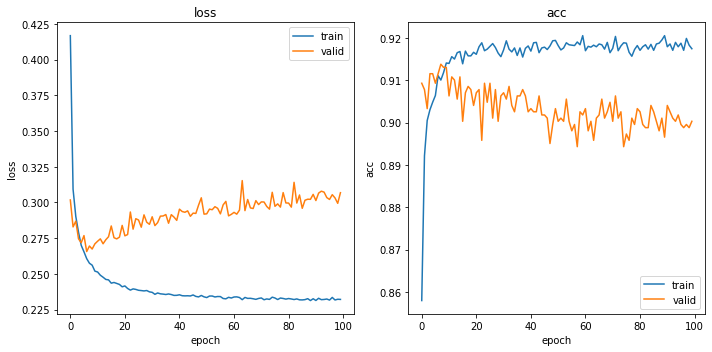

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig74.png')